In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dense
from tensorflow.keras.layers import AvgPool2D, GlobalAveragePooling2D, MaxPool2D, ZeroPadding2D
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout
from tensorflow.keras.layers import ReLU, concatenate
import tensorflow.keras.backend as K

import pandas as pd
import numpy as np
import os
import keras
import random
import cv2
import math
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from tensorflow.keras.applications.densenet import preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array
from tensorflow.keras.optimizers import Adam,Adadelta,Adagrad

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

from skimage.transform import resize

import warnings
warnings.filterwarnings("ignore")

# Creating Densenet201
def Densenet(input_shape, n_classes, filters = 32):
    
    #batch norm + relu + conv
    def bn_rl_conv(x,filters,kernel=1,strides=1):
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv2D(filters, kernel, strides=strides,padding = 'same')(x)
        return x
    
    def dense_block(x, repetition):
        for _ in range(repetition):
            y = bn_rl_conv(x, 4*filters)
            y = bn_rl_conv(y, filters, 3)
            x = concatenate([y,x])
        return x
        
    def transition_layer(x):
        x = bn_rl_conv(x, K.int_shape(x)[-1] //2 )
        x = AvgPool2D(2, strides = 2, padding = 'same')(x)
        return x
    
    input = Input (input_shape)
    x = ZeroPadding2D(0)(input)
    x = Conv2D(64, 7, strides = 2, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = ZeroPadding2D(0)(x)
    x = MaxPool2D(3, strides = 2, padding = 'same')(x)
    
    for repetition in [6, 12, 24, 16]:
        d = dense_block(x, repetition)
        x = transition_layer(d)
        
    x = GlobalAveragePooling2D()(d)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(1024,activation='relu')(x) 
    x = Dense(256,activation='relu')(x)
    
    #x = BatchNormalization()(x)
    #x = Dropout(0.5)(x)
    #x = Dense(128,activation='relu')(x)
    
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    output = Dense(n_classes, activation = 'softmax')(x)
    model = Model(input, output)
    return model

input_shape = (128, 128, 3)
n_classes = 2
model = Densenet(input_shape, n_classes)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 128, 128, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_121 (Conv2D)             (None, 64, 64, 64)   9472        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
batch_normalization_123 (BatchN (None, 64, 64, 64)   256         conv2d_121[0][0]                 
____________________________________________________________________________________________

In [10]:
def selection(DATADIR, CATEGORIES):
    images = []
    data = []
    for category in CATEGORIES:
        path_cases = os.path.join(DATADIR, category)
        n = len(os.listdir(path_cases))
        for i in range(n):
            path_case = os.path.join(path_cases, "{} ({})".format(CATEGORIES[category], i+1))
            for img in os.listdir(path_case):
                data = np.load(path_case+'/'+img)
                k = len(data)//2
                new_img = data[k]
                img_arr = np.array(new_img)
                img_arr = resize(img_arr, output_shape = (128, 128, 3), preserve_range=True)
                if(np.min(img_arr) == 0) :
                    img_arr = img_arr/255
                else :
                    img_arr = img_arr/2048
                    img_arr = img_arr + 1
                    img_arr = img_arr/2
                images.append([img_arr, category])
                break
    return images
# def selection(DATADIR, CATEGORIES):
#     img_array = []
#     for category in CATEGORIES:
#         path_cases = os.path.join(DATADIR, category)
#         n = len(os.listdir(path_cases))
#         for i in range(n):
#             path_case = os.path.join(path_cases, "{} ({})".format(CATEGORIES[category], i+1))
#             k = 0
#             m = len(os.listdir(path_case))//2
#             for img in os.listdir(path_case):
#                 k += 1
#                 if m==k:
#                     img_arr = cv2.imread(os.path.join(path_case, img))
#                     new_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
#                     img_array.append([new_arr, category])
#                     break
#     return img_array

In [11]:
CATEGORIES = {"done_non-COVID-19" : 0, "done_COVID-19" : 1}
CATEGORIES2 = {"non-COVID-19/CP" : 0, "COVID-19" : 1}
DATADIR = "data/"
IMG_SIZE = 128
data_array = selection(DATADIR, CATEGORIES)
print(len(data_array))

828


In [12]:
random.seed(0)
random.shuffle(data_array)
image_data = []
classes = []
for d in data_array:
    image_data.append(d[0])
    classes.append(d[1])
image_data = np.array(image_data, dtype="float32") / 255.0
classes = np.array(classes)
mlb = LabelBinarizer()
classes = mlb.fit_transform(classes)
classes = np.hstack((classes, 1 - classes))

In [13]:
(xtrain,xtest,ytrain,ytest)=train_test_split(image_data,classes,test_size=0.3,random_state=42)
print(xtrain.shape, xtest.shape)

(579, 128, 128, 3) (249, 128, 128, 3)


In [14]:
for layer in model.layers[:-8]:
    layer.trainable=False
    
for layer in model.layers[-8:]:
    layer.trainable=True
    
model.compile(optimizer='Adagrad',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 128, 128, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_121 (Conv2D)             (None, 64, 64, 64)   9472        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
batch_normalization_123 (BatchN (None, 64, 64, 64)   256         conv2d_121[0][0]                 
____________________________________________________________________________________________

In [19]:
anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=4, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

datagen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip=True, shear_range=0.2)


datagen.fit(xtrain)
# Fits-the-model
history = model.fit_generator(datagen.flow(xtrain, ytrain, batch_size=128),
               steps_per_epoch=xtrain.shape[0] //128,
               epochs=100,
               verbose=2,
               callbacks=[anne, checkpoint],
               validation_data=(xtrain, ytrain))

Epoch 1/100
4/4 - 4s - loss: 0.6779 - accuracy: 0.6541 - val_loss: 0.6748 - val_accuracy: 0.6477

Epoch 00001: val_loss improved from inf to 0.67484, saving model to model.h5
Epoch 2/100
4/4 - 4s - loss: 0.6743 - accuracy: 0.6585 - val_loss: 0.6748 - val_accuracy: 0.6477

Epoch 00002: val_loss improved from 0.67484 to 0.67483, saving model to model.h5
Epoch 3/100
4/4 - 4s - loss: 0.6766 - accuracy: 0.6186 - val_loss: 0.6748 - val_accuracy: 0.6477

Epoch 00003: val_loss improved from 0.67483 to 0.67481, saving model to model.h5
Epoch 4/100
4/4 - 4s - loss: 0.6763 - accuracy: 0.6231 - val_loss: 0.6748 - val_accuracy: 0.6442

Epoch 00004: val_loss improved from 0.67481 to 0.67475, saving model to model.h5
Epoch 5/100
4/4 - 4s - loss: 0.6752 - accuracy: 0.6504 - val_loss: 0.6747 - val_accuracy: 0.6459

Epoch 00005: val_loss improved from 0.67475 to 0.67473, saving model to model.h5
Epoch 6/100
4/4 - 4s - loss: 0.6745 - accuracy: 0.6164 - val_loss: 0.6747 - val_accuracy: 0.6477

Epoch 00006

Epoch 47/100
4/4 - 4s - loss: 0.6761 - accuracy: 0.6253 - val_loss: 0.6740 - val_accuracy: 0.6200

Epoch 00047: val_loss improved from 0.67402 to 0.67399, saving model to model.h5
Epoch 48/100
4/4 - 4s - loss: 0.6778 - accuracy: 0.6133 - val_loss: 0.6740 - val_accuracy: 0.6200

Epoch 00048: val_loss improved from 0.67399 to 0.67398, saving model to model.h5
Epoch 49/100
4/4 - 4s - loss: 0.6744 - accuracy: 0.6208 - val_loss: 0.6740 - val_accuracy: 0.6200

Epoch 00049: val_loss improved from 0.67398 to 0.67396, saving model to model.h5
Epoch 50/100
4/4 - 4s - loss: 0.6740 - accuracy: 0.6009 - val_loss: 0.6739 - val_accuracy: 0.6079

Epoch 00050: val_loss improved from 0.67396 to 0.67395, saving model to model.h5
Epoch 51/100
4/4 - 4s - loss: 0.6728 - accuracy: 0.6430 - val_loss: 0.6739 - val_accuracy: 0.6028

Epoch 00051: val_loss improved from 0.67395 to 0.67393, saving model to model.h5
Epoch 52/100
4/4 - 4s - loss: 0.6734 - accuracy: 0.6231 - val_loss: 0.6739 - val_accuracy: 0.6028

E


Epoch 00093: val_loss improved from 0.67326 to 0.67324, saving model to model.h5
Epoch 94/100
4/4 - 4s - loss: 0.6781 - accuracy: 0.6172 - val_loss: 0.6732 - val_accuracy: 0.6390

Epoch 00094: val_loss improved from 0.67324 to 0.67322, saving model to model.h5
Epoch 95/100
4/4 - 4s - loss: 0.6770 - accuracy: 0.6364 - val_loss: 0.6732 - val_accuracy: 0.6459

Epoch 00095: val_loss improved from 0.67322 to 0.67320, saving model to model.h5
Epoch 96/100
4/4 - 4s - loss: 0.6745 - accuracy: 0.5938 - val_loss: 0.6732 - val_accuracy: 0.6390

Epoch 00096: val_loss improved from 0.67320 to 0.67318, saving model to model.h5
Epoch 97/100
4/4 - 4s - loss: 0.6716 - accuracy: 0.6270 - val_loss: 0.6732 - val_accuracy: 0.6304

Epoch 00097: val_loss improved from 0.67318 to 0.67316, saving model to model.h5
Epoch 98/100
4/4 - 3s - loss: 0.6730 - accuracy: 0.6408 - val_loss: 0.6732 - val_accuracy: 0.6287

Epoch 00098: val_loss improved from 0.67316 to 0.67316, saving model to model.h5
Epoch 99/100
4/4 -

In [21]:
ypred = model.predict(xtest)

total = 0
accurate = 0
accurateindex = []
wrongindex = []
for i in range(len(ypred)):
    if np.argmax(ypred[i]) == np.argmax(ytest[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)
        
    total += 1
    
print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')

Total-test-data; 249 	accurately-predicted-data: 147 	 wrongly-predicted-data:  102
Accuracy: 59.036 %


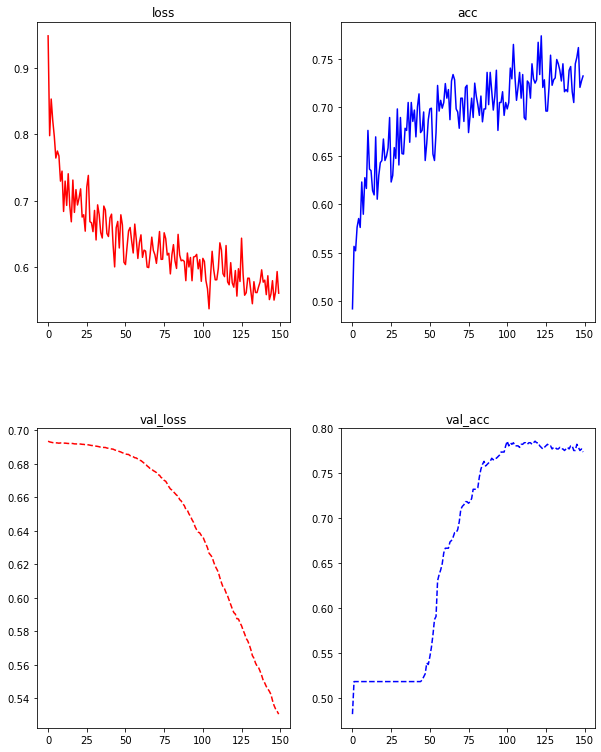

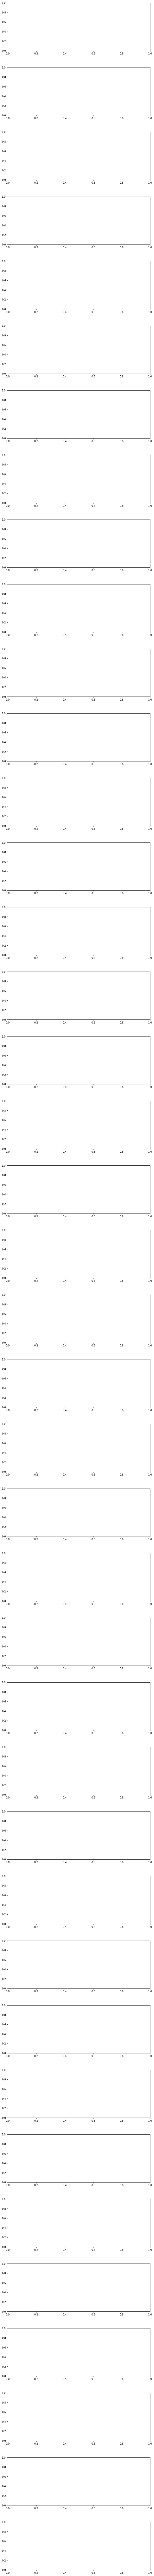

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(10, 7))
plt.subplots_adjust(left=0.125,bottom=0.1, right=0.9, top=1.5, wspace=0.2, hspace=0.35)

ax[0, 0].set_title('loss')
ax[0, 0].plot(history.history['loss'], 'r')
ax[0, 1].set_title('acc')
ax[0, 1].plot(history.history['accuracy'], 'b')

ax[1, 0].set_title('val_loss')
ax[1, 0].plot(history.history['val_loss'], 'r--')
ax[1, 1].set_title('val_acc')
ax[1, 1].plot(history.history['val_accuracy'], 'b--')
    
preds = model.predict(xtrain)

fig1, ax1 = plt.subplots(40, 1, figsize=(10, 100))
plt.subplots_adjust(left=0.125,bottom=0.1, right=0.9, top=1.5, wspace=0.2, hspace=0.35)

# for i in range(40):
#     ax1[i].imshow(xtrain[i].squeeze())
#     ax1[i].title.set_text(str(preds[i]))